# Ovrlpy applied to vizgen receptor data map



#### Imports:

#### Parameter definition:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from ovrlpy import ovrlp

In [2]:
import random

random.seed(42)

In [3]:
from pathlib import Path

slice_nr = 2

data_path = Path("/dh-projects/ag-ishaque/raw_data/vizgen-merfish/vz-receptor-showcase")

coordinate_file = (
    data_path
    / f"Slice{slice_nr}"
    / "Replicate1"
    / f"detected_transcripts_S{slice_nr}R1.csv"
)

signature_matrix_file = Path(
    "/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv"
)

In [6]:
# Load coordinates
columns = ["global_x", "global_y", "global_z", "gene"]

coordinate_df = pd.read_csv(
    coordinate_file, sep=",", usecols=columns, dtype={"gene": "category"}
).loc[lambda df: ~df["gene"].str.contains("Blank")]

coordinate_df.columns = ["x", "y", "z", "gene"]

coordinate_df["gene"] = coordinate_df["gene"].cat.remove_unused_categories()

coordinate_df["x"] -= coordinate_df["x"].min()
coordinate_df["y"] -= coordinate_df["y"].min()
coordinate_df["z"] -= coordinate_df["z"].min()

genes = coordinate_df["gene"].cat.categories

coordinate_df.head()

x           y    z    gene
0    3.902843  3928.51322  5.0  Adgre1
1  130.573806  3950.67072  5.0  Adgre1
2    6.723472  3743.21982  5.0  Adgre1
3   40.435756  3650.52132  0.0    Grm4
4   30.430046  3555.96932  0.0  P2yr13

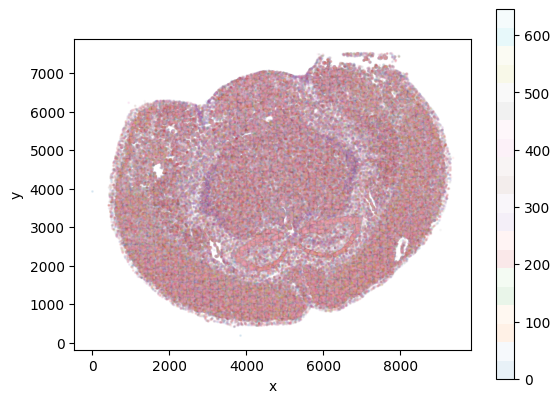

In [5]:
coordinate_df[::200].plot.scatter(
    x="x", y="y", s=1, c=coordinate_df[::200].gene.cat.codes, cmap="tab20", alpha=0.1
)
plt.gca().set_aspect("equal")

In [8]:
signatures = pd.read_csv(signature_matrix_file, index_col=0)

signatures = (
    signatures.T.groupby(lambda x: x.split("_")[1].split(" ")[0].split("-")[0])
    .apply(lambda x: x.mean(0))
    .T
).loc[signatures.index[signatures.index.isin(genes)]]


signatures.columns = signatures.columns.str.replace("/", "-")

In [9]:
integrity, signal, visualizer = ovrlp.compute_coherence_map(df=coordinate_df)

Running vertical adjustment
Analyzing in 3d mode:
determining pseudocells:
Searching within x:(0, 3856), y:(0, 3012), n_molecules:48574461
Using bandwidth: 2.5, min_expression: 0.5, min_pixel_distance: 7.0
found 69275 pseudocells
sampling expression:


Mc2r: 100%|██████████| 483/483 [00:43<00:00, 11.15it/s]    


Modeling 10 pseudo-celltype clusters


/dh-projects/ag-ishaque/analysis/muellni/envs/ovrlpy/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dh-projects/ag-ishaque/analysis/muellni/envs/ovrlpy/lib/python3.12/site-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[   0 1071 2142 3213 4284 5355 6426 7497 8568 9640] [   0 1075 2151 3227 4302 5378 6454 7530]


 19%|█▉        | 12/63 [00:49<05:40,  6.68s/it]/dh-projects/ag-ishaque/analysis/muellni/envs/ovrlpy/lib/python3.12/site-packages/ovrlpy/_utils.py:596: RuntimeWarning: invalid value encountered in divide
  patch_cosine_similarity = np.sum(
100%|██████████| 63/63 [06:08<00:00,  5.85s/it]


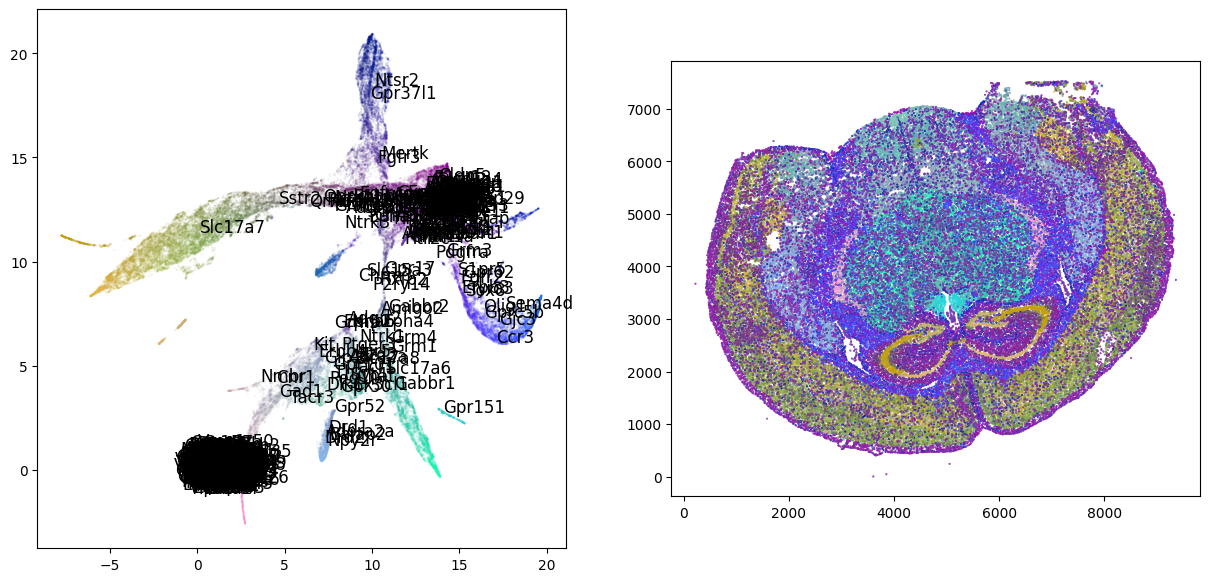

In [10]:
visualizer.plot_fit()

12


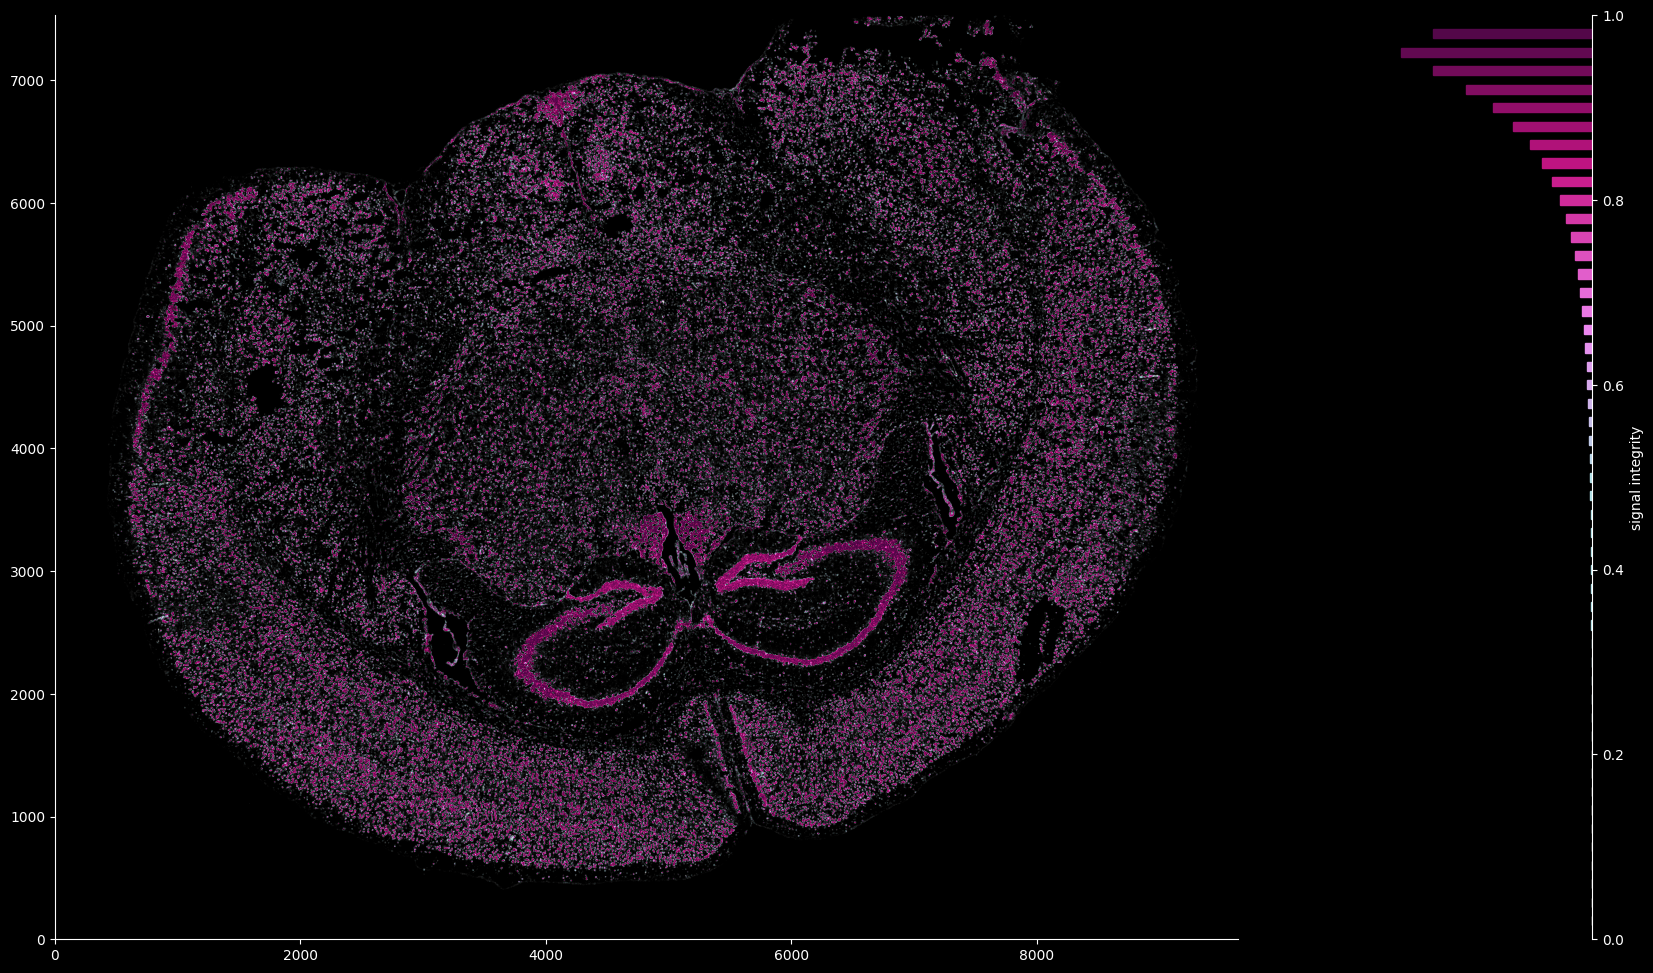

In [11]:
fig, ax = ovrlp.plot_signal_integrity(integrity, signal, signal_threshold=3)

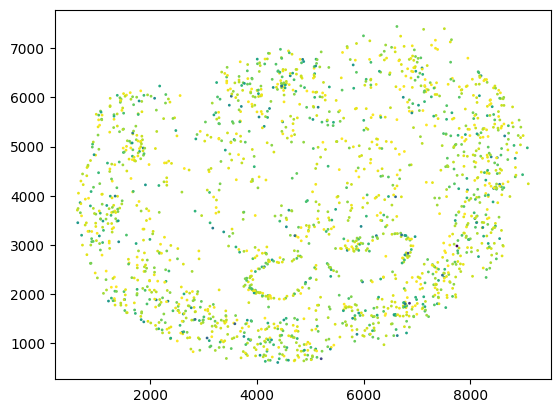

In [21]:
doublet_df = ovrlp.detect_doublets(integrity, signal, signal_cutoff=5)

_ = plt.scatter(
    doublet_df["x"], doublet_df["y"], c=doublet_df["integrity"], s=1, cmap="viridis_r"
)

/dh-projects/ag-ishaque/analysis/muellni/envs/ovrlpy/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


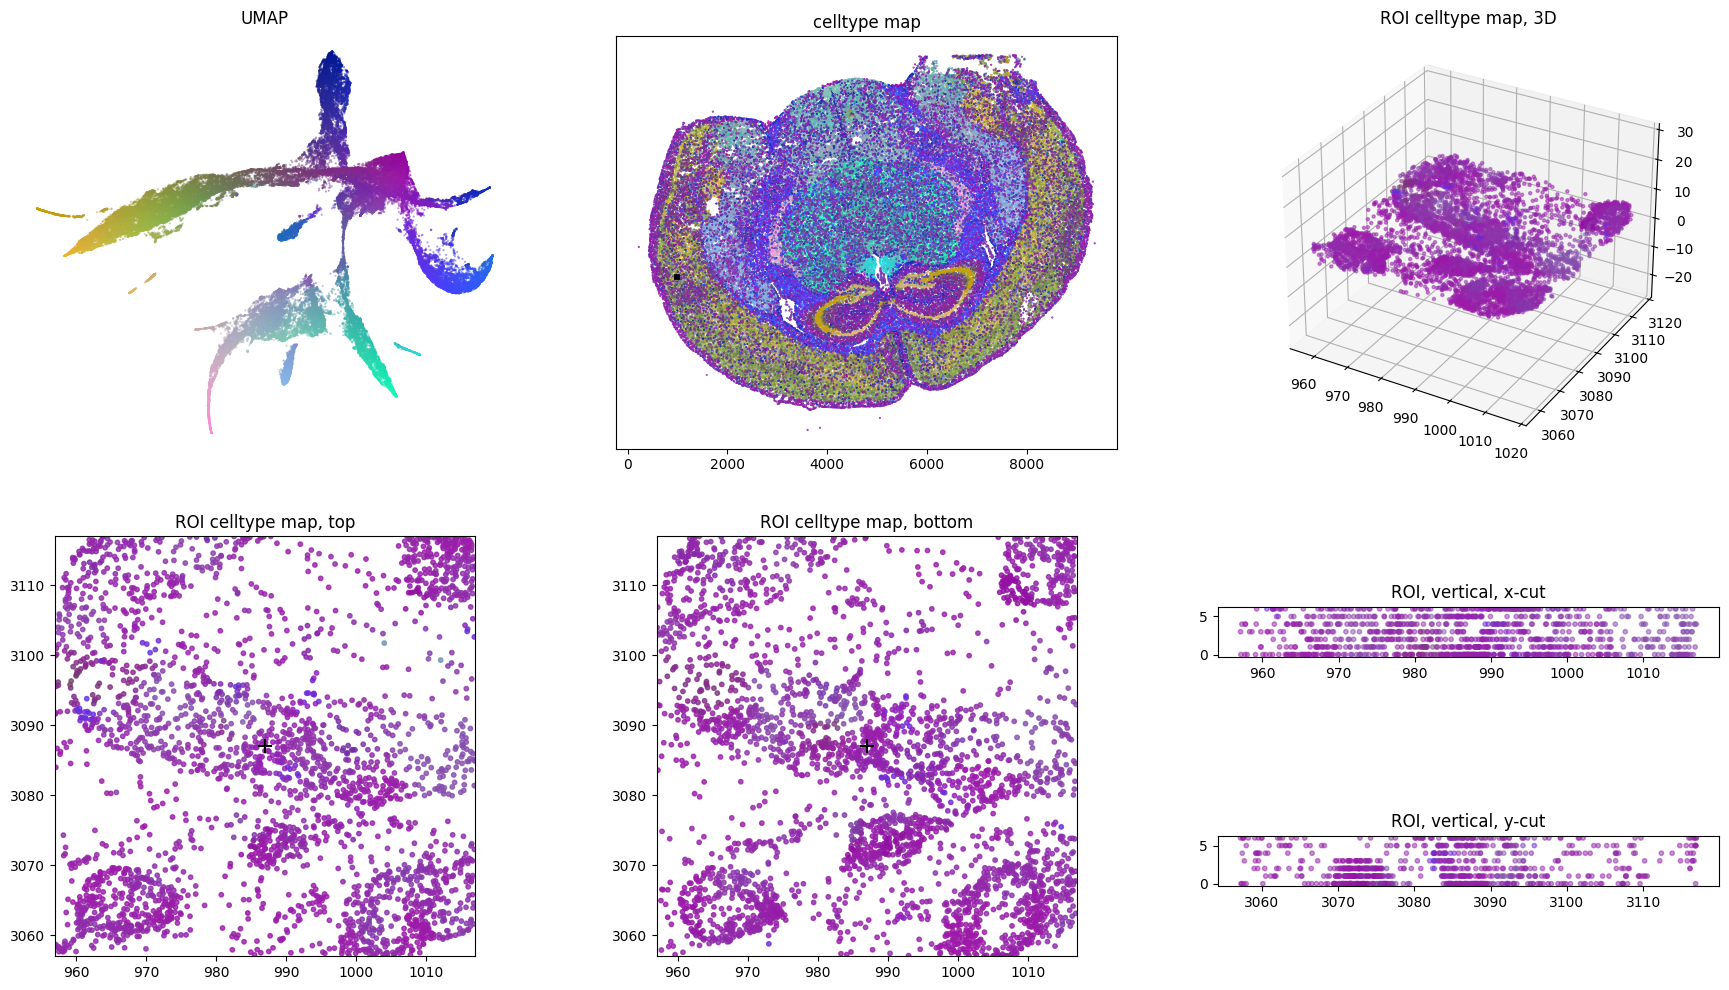

In [20]:
window_size = 30
doublet_case = 0

x, y = doublet_df.loc[doublet_case, ["x", "y"]]

subsample = visualizer.subsample_df(x, y, coordinate_df, window_size=window_size)
subsample_embedding, subsample_embedding_color = visualizer.transform(subsample)

visualizer.plot_instance(
    subsample, subsample_embedding_color, x, y, window_size=window_size, rasterized=True
)